In [21]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [458]:
np.random.seed(2019)
N1 = 411
dist1 = np.exp(np.random.normal(2,0.5,size=N1))
N2 = 754
dist2 = np.random.normal(2,0.5,size=N2)
N3 = 235
dist3 = np.random.exponential(size=N3)

In [459]:
perc = np.linspace(0,100,11)
perc_arr = np.vstack((perc,perc,perc))

In [460]:
bins_arr = np.vstack((np.percentile(dist1,perc_arr[0]),
                      np.percentile(dist2,perc_arr[1]),
                      np.percentile(dist3,perc_arr[2])))

In [461]:
x = pc_sample_arr((N1,N2,N3), perc_arr, bins_arr)

In [462]:
def pc_sample_arr(N,percentiles,bins):
    draws = np.zeros(0)
    for i in range(len(N)):
        draws = np.concatenate((draws,pc_sample(N[i], percentiles[i], bins[i])))
    return draws
        
def pc_sample(N,percentiles,bins):
    diff = np.diff(percentiles)
    assert np.allclose(diff[0],diff)
    n = int(N/diff.size)
    draws = np.random.uniform(low=bins[:-1], high=bins[1:], size=(n,diff.size)).ravel()
    return np.concatenate((draws, np.random.uniform(low=bins[0], high=bins[-1], size=(N-n*diff.size))))

(411,) (411,)


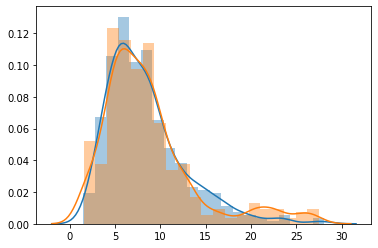

In [463]:
sns.distplot(dist1)
sns.distplot(x[:N1])
print(dist1.shape, x[:N1].shape)

(754,) (754,)


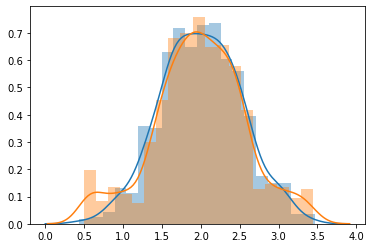

In [464]:
sns.distplot(dist2)
sns.distplot(x[N1:N1+N2])
print(dist2.shape, x[N1:N1+N2].shape)

(235,) (235,)


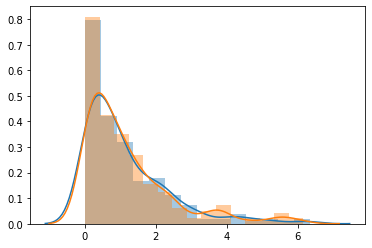

In [465]:
sns.distplot(dist3)
sns.distplot(x[N1+N2:N1+N2+N3])
print(dist3.shape, x[N1+N2:N1+N2+N3].shape)

(41,) (41,)


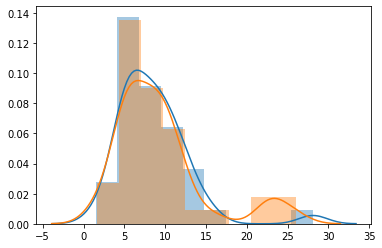

In [383]:
sns.distplot(dist)
sns.distplot(x)
print(dist.shape,x.shape)

# Method of simulated moments

Import the different libaries and the SMD module

In [1]:
from consav import runtools
runtools.write_numba_config(disable=0,threads=4)

%matplotlib inline
%load_ext autoreload
%autoreload 2

# Local modules
from Model import RetirementClass
import funs
import figs
import transitions
import SimulatedMinimumDistance as SMD

# Global modules
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import pickle

# Singles

Function to make moments and weights for singles

In [136]:
def mom_fun(sim,moments=True):
    
    # unpack
    states = np.unique(sim.states,axis=0)
    MA = sim.states[:,0]
    ST = sim.states[:,1]    
    probs = sim.probs[:,1:,0]*100 # 1: means exclude age 57 (since first prob is at 58)
        
    # initialize
    T = probs.shape[1]
    N = len(states)
    mom = np.zeros((T,N))
    
    # compute moments
    for i in range(N):
        ma = states[i,0]
        st = states[i,1]
        idx = np.nonzero((MA==ma) & (ST==st))[0]
        if moments:
            mom[:,i] = np.nanmean(probs[idx,:],axis=0)
        else:
            mom[:,i] = np.nanstd(probs[idx,:],axis=0)
    return mom.ravel()

def mom_fun_total(sim):
    
    # unpack
    probs = sim.probs[:,1:,0]*100
    MA = [0, 1, np.array([0,1])] # women, men and both
    
    # initialize
    T = probs.shape[1]
    N = len(MA)
    mom = np.zeros((T,N))
    
    for i in range(N):
        idx = np.nonzero(np.isin(sim.states[:,0],MA[i]))[0]
        mom[:,i] = np.nanmean(probs[idx,:],axis=0)
    return mom.ravel(order='F')

def weight_matrix(std):
    std_inv = np.zeros(std.shape)
    idx = np.nonzero(std>0)[0]
    std_inv[idx] = 1/std[idx]
    return np.eye(std.size)*std_inv

Generate or load data

In [3]:
#data_seed = 2019
#data = RetirementClass(sim_seed=data_seed)
#data.par.simT = 12 # 68-57+1
#data.solve()
#data.simulate()
#mom_data = mom_fun(data.sim)
#mom_se = mom_fun(data.sim,moments=False)
#np.savetxt('mom.txt', mom_data, delimiter=" ") # manually write to excel
#np.savetxt('se.txt', mom_se, delimiter=" ")
moments = pd.read_excel('SASdata/single_moments.xlsx')
mom_data = moments['Moments'].to_numpy()
weight = weight_matrix(moments['SE'].to_numpy())

Set up model for estimation

In [4]:
est_seed = 1000 # new seed
model_base = RetirementClass(sim_seed = est_seed)
model_base.par.simT = 12
model_base.solve() # jit function
model_base.simulate() # jit function

Set up estimation

In [6]:
# Parameters to be estimated (and guess)
true = [model_base.par.alpha_0_male, model_base.par.alpha_0_female, model_base.par.alpha_1, model_base.par.sigma_eta]
theta0 = [i*0.1 for i in true]
add_str = '_est'
est_par = ["alpha_0_male", "alpha_0_female", "alpha_1", "sigma_eta"]

# Setup estimation
smd_base = SMD.SimulatedMinimumDistance(model_base,mom_data,mom_fun,print_iter=[True,50],save=True,options={'disp':True})
smd_base.est_par = est_par
smd_base.est_par_save = {'{}'.format(i):[] for i in est_par}
smd_base.est_par_save['obj_func'] = []

Run estimation

In [8]:
tic = time.time()
smd_base.estimate(theta0,weight)
theta_base = smd_base.est
toc = time.time()

Iteration: 50 (1.34 minutes)
 alpha_0_male=0.044 alpha_0_female=-0.036 alpha_1=-0.020 sigma_eta=0.306 -> 990.8886
Iteration: 100 (0.79 minutes)
 alpha_0_male=0.333 alpha_0_female=0.139 alpha_1=-0.136 sigma_eta=0.507 -> 277.5170
Iteration: 150 (0.78 minutes)
 alpha_0_male=0.264 alpha_0_female=0.226 alpha_1=-0.166 sigma_eta=0.593 -> 156.4273
Iteration: 200 (0.74 minutes)
 alpha_0_male=0.143 alpha_0_female=0.145 alpha_1=0.048 sigma_eta=0.379 -> 4.9490
Iteration: 250 (0.75 minutes)
 alpha_0_male=0.163 alpha_0_female=0.162 alpha_1=0.050 sigma_eta=0.444 -> 0.8614
Iteration: 300 (0.74 minutes)
 alpha_0_male=0.163 alpha_0_female=0.162 alpha_1=0.049 sigma_eta=0.442 -> 0.8042
Optimization terminated successfully.
         Current function value: 0.791161
         Iterations: 196
         Function evaluations: 348


Save estimates and resolve model

In [281]:
SingleEst = dict(zip(est_par, theta_base))
with open('estimates/Single.pickle', 'wb') as handle:
    pickle.dump(SingleEst, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [282]:
for p in range(len(est_par)):
    setattr(model_base.par,est_par[p],theta_base[p]) 
model_base.solve()
model_base.simulate()

Estimates

In [232]:
print('Parameter:       ', est_par)
print('True:            ', np.round(true, 3))
print('Estimated:       ', np.round(theta_base, 3))
print('bias:            ', np.round(theta_base-true, 3))
print('Estimation time: ', round((toc-tic)/60,2), 'minutes')

Parameter:        ['alpha_0_male', 'alpha_0_female', 'alpha_1', 'sigma_eta']
True:             [0.16  0.16  0.053 0.435]
Estimated:        [0.163 0.162 0.049 0.442]
bias:             [ 0.003  0.002 -0.004  0.007]
Estimation time:  5.36 minutes


Model fit

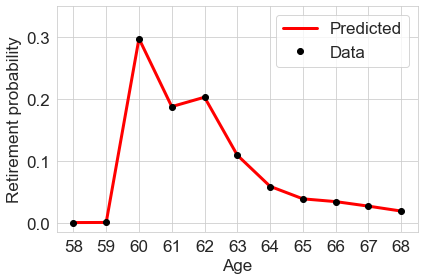

In [293]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
figs.retirement_probs(model_base,ax,MA=[1],moments=True)
fig.tight_layout()
fig.savefig('figs/ModelFit/SingleMen.png')

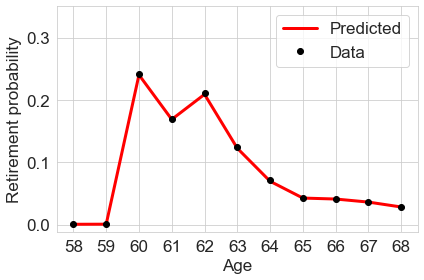

In [292]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
figs.retirement_probs(model_base,ax,MA=[0],moments=True)
fig.tight_layout()
fig.savefig('figs/ModelFit/SingleWomen.png')

# Couples

Function to make moments and weights for couples

In [207]:
def mom_fun_c(sim,moments=True):
    
    # unpack
    states = np.unique(sim.states,axis=0)
    AD = sim.states[:,0]
    ST_h = sim.states[:,1]    
    ST_w = sim.states[:,2]
    probs_h = sim.probs[:,1+4:,1]*100 # 1: means exclude age 57 (since first prob is at 58)
    probs_w = sim.probs[:,1+4:,0]*100 # and assuming ad_min=4
    
    # initialize
    T = probs_h.shape[1]
    N = len(states)
    mom = np.zeros((T*2,N))
    
    # compute moments
    for i in range(N):
        ad = states[i,0]
        st_h = states[i,1]
        st_w = states[i,2]
        idx = np.nonzero((AD==ad) & (ST_h==st_h) & (ST_w==st_w))[0]
        if moments:
            mom[:T,i] = np.nanmean(probs_h[idx,:],axis=0)
            #mom[T:,i] = np.nanmean(probs_w[idx,:],axis=0)           
        else:
            mom[:T,i] = np.nanstd(probs_h[idx,:],axis=0)
            #mom[T:,i] = np.nanstd(probs_w[idx,:],axis=0)            
    #mom = mom.ravel()
    #mom[np.isnan(mom)] = 0
    return mom
    #return mom.ravel()

def mom_fun_c_total(sim):
    
    # unpack
    probs = sim.probs[:,1+4:]*100
    MA = [0, 1, np.array([0,1])] # women, men and both
    
    # compute
    T = probs.shape[1]
    mom = np.zeros((T,3))
    mom[:,0] = np.nanmean(probs[:,:,1],axis=0) # men
    mom[:,1] = np.nanmean(probs[:,:,0],axis=0) # women
    mom[:,2] = np.nanmean(probs,axis(0,2))     # both
    return mom.ravel(order='F')

def weight_matrix_c(std):
    std_inv = np.zeros(std.shape)
    idx = np.nonzero(std>0.01)[0]
    std_inv[idx] = 1/std[idx]
    return np.eye(std.size)*std_inv

Generate or load data

In [68]:
#data_seed = 2019
#data = RetirementClass(couple=True, sim_seed=data_seed)
#data.par.simT = 12 # 68-57+1
#data.solve()
#data.simulate()
#mom_data_c = mom_fun_c(data.sim)
#mom_se_c = mom_fun_c(data.sim,moments=False)
#np.savetxt('mom.txt', mom_data_c, delimiter=" ") # manually write to excel
#np.savetxt('se.txt', mom_se_c, delimiter=" ")
moments = pd.read_excel('SASdata/couple_moments.xlsx')
mom_h = moments['Moments_H'].to_numpy()
mom_w = moments['Moments_W'].to_numpy()
se_h = moments['SE_H'].to_numpy()
se_w = moments['SE_H'].to_numpy()
mom_data_c = np.hstack((mom_h,mom_w))
weight_c = weight_matrix_c(np.hstack((se_h,se_w)))

In [213]:
sim = Couple.sim

In [332]:
states = np.unique(sim.states,axis=0)
AD = sim.states[:,0]
ST_h = sim.states[:,1]    
ST_w = sim.states[:,2]
probs_h = sim.probs[:,1+4:,1]*100 # 1: means exclude age 57 (since first prob is at 58)
probs_w = sim.probs[:,1+4:,0]*100 # and assuming ad_min=4
    
# initialize
T = probs_h.shape[1]
N = len(states)
mom = np.zeros((T*2,N))
    
# compute moments
for i in range(N):
    ad = 0#states[i,0]
    st_h = 0#states[i,1]
    st_w = 0#states[i,2]
    idx = np.nonzero((AD==ad) & (ST_h==st_h) & (ST_w==st_w))[0]
    #if moments:
    mom[:T,i] = np.nanmean(probs_h[idx,:],axis=0)
    #mom[T:,i] = np.nanmean(probs_w[idx,:],axis=0)           
    #else:
    ##    mom[:T,i] = np.nanstd(probs_h[idx,:],axis=0)
     #   mom[T:,i] = np.nanstd(probs_w[idx,:],axis=0)    

In [337]:
par = Couple.par

In [338]:
data = pd.read_excel('SASdata/couple_formue.xlsx')
states = par.iterator
n_groups = (data['Frac'].to_numpy()*par.simN).astype(int)
n_groups[-1] = par.simN-np.sum(n_groups[:-1])   # assure it sums to simN

In [346]:
n_groups

array([   6,    2, 1113,   66,   12,    3,  111,  111, 1113,  245, 5010,
       1670,  278,   13,  239, 1113,    6,    2, 1113,   66,   12,    3,
        111,  111, 1113,  245, 5010, 1670,  278,   13,  239, 1113,    6,
          2, 1113,   66,   12,    3,  111,  111, 1113,  245, 5010, 1670,
        278,   13,  239, 1113,    6,    2, 1113,   66,   12,    3,  111,
        111, 1113,  245, 5010, 1670,  278,   13,  239, 1113,    6,    2,
       1113,   66,   12,    3,  111,  111, 1113,  245, 5010, 1670,  278,
         13,  239, 1113,    6,    2, 1113,   66,   12,    3,  111,  111,
       1113,  245, 5010, 1670,  278,   13,  239, 1113,    6,    2, 1113,
         66,   12,    3,  111,  111, 1113,  245, 5010, 1670,  278,   13,
        239, 1113,    6,    2, 1113,   66,   12,    3,  111,  111, 1113,
        245, 5010, 1670,  278,   13,  239, 1113,    6,    2, 1113,   66,
         12,    3,  111,  111, 1113,  245, 5010, 1670,  278,   13,  239,
       1168])

In [343]:
np.nonzero(n_groups < 100)[0]

array([  0,   1,   3,   4,   5,  13,  16,  17,  19,  20,  21,  29,  32,
        33,  35,  36,  37,  45,  48,  49,  51,  52,  53,  61,  64,  65,
        67,  68,  69,  77,  80,  81,  83,  84,  85,  93,  96,  97,  99,
       100, 101, 109, 112, 113, 115, 116, 117, 125, 128, 129, 131, 132,
       133, 141], dtype=int64)

In [335]:
np.nanmean(probs_h[idx],axis=0)

array([1.03816640e-02, 3.95736377e-02, 1.32292033e-01, 4.38400548e-01,
       1.44366956e+00, 4.11993635e+00, 1.15868625e+01, 1.89681645e+01,
       2.26727762e+01, 2.13183282e+01, 0.00000000e+00])

In [323]:
idx

array([78856, 78857, 78858, 78859, 78860, 78861, 78862, 78863, 78864,
       78865, 78866, 78867, 78868, 78869, 78870, 78871, 78872, 78873,
       78874, 78875, 78876, 78877, 78878, 78879, 78880, 78881, 78882,
       78883, 78884, 78885, 78886, 78887, 78888, 78889, 78890, 78891,
       78892, 78893, 78894, 78895, 78896, 78897, 78898, 78899, 78900,
       78901, 78902, 78903, 78904, 78905, 78906, 78907, 78908, 78909,
       78910, 78911, 78912, 78913, 78914, 78915, 78916, 78917, 78918,
       78919, 78920, 78921], dtype=int64)

In [309]:
Couple.sim.alive[idx,:,1]

array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [310]:
Couple.sim.alive[idx,:,0]

array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])

In [311]:
Couple.sim.d[idx,:,1]

array([[ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1., nan, nan],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1., nan, nan, nan, nan,  0.],
       [ 1.,  1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.,  1., nan, nan],
       [ 1.,  1.,  1., nan, nan, nan, nan,  0., nan, nan, nan, nan],
       [ 0.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1., nan, nan],
       [ 1.,  1.,  1., nan, nan, nan, nan, nan, nan, nan, nan, nan]])

In [312]:
Couple.sim.d[idx,:,0]

array([[ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  0.,  0., nan, nan, nan],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  0., nan, nan, nan, nan, nan],
       [ 1.,  1.,  1.,  1.,  0.,  0.,  0.,  0.,  0., nan, nan, nan],
       [ 1.,  1.,  1., nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [ 1.,  1.,  1.,  1.,  1.,  0.,  0.,  0.,  0., nan, nan, nan],
       [ 1.,  1.,  1., nan, nan, nan, nan, nan, nan, nan,  0., nan]])

In [313]:
probs_h[idx]

array([[1.74652010e-02, 5.87555491e-02, 1.59391864e-01, 6.28612396e-01,
        1.87255077e+00, 4.79303028e+00, 1.26325929e+01, 3.73790460e+01,
        4.11727609e+01,            nan,            nan],
       [1.74652010e-02, 4.89395892e-02, 1.74453521e-01, 6.45122047e-01,
        2.12885262e+00, 5.29991283e+00,            nan,            nan,
                   nan,            nan,            nan],
       [1.74652010e-02, 5.62243070e-02, 1.78348180e-01, 7.00165714e-01,
        2.57860493e+00, 6.53498634e+00, 1.55236887e+01, 3.76425714e+01,
        4.13821832e+01,            nan,            nan],
       [1.74652010e-02, 4.95559852e-02,            nan,            nan,
                   nan,            nan,            nan, 0.00000000e+00,
                   nan,            nan,            nan],
       [1.74652010e-02, 6.14011718e-02, 2.04772674e-01, 6.04107964e-01,
        2.12091985e+00, 7.13396148e+00, 1.61602184e+01, 3.78555014e+01,
        4.16348963e+01,            nan,            n

In [280]:
ST_w.shape

(100000,)

In [275]:
idx

array([88840, 88841, 88842, 88843, 88844, 88845], dtype=int64)

In [274]:
probs_h[idx]

array([[2.20245169e-02, 7.44000346e-02, 2.48788497e-01, 7.97358468e-01,
        2.20340197e+00, 5.79908643e+00, 1.46224091e+01, 3.68749241e+01,
                   nan,            nan,            nan],
       [2.08517887e-02,            nan,            nan,            nan,
                   nan,            nan,            nan,            nan,
                   nan,            nan,            nan],
       [2.08517887e-02, 7.27401796e-02, 2.26793583e-01, 7.28277008e-01,
        1.93600283e+00, 4.77622893e+00, 1.51023034e+01, 3.70455736e+01,
                   nan,            nan,            nan],
       [2.08517887e-02, 7.28004809e-02, 2.53648252e-01, 7.67545415e-01,
        1.95229886e+00, 5.03041328e+00, 1.50931665e+01, 3.70176043e+01,
                   nan,            nan,            nan],
       [2.08517887e-02, 6.89132554e-02, 2.01485326e-01, 6.96867796e-01,
                   nan,            nan,            nan,            nan,
                   nan,            nan,            n

In [86]:
print(Couple.par.simT)
print(Couple.par.sim_seed)

12
2019


In [270]:
#Couple.solve(recompute=True)
Couple.simulate(recompute=True)

In [88]:
 mom_sim = mom_fun_c(Couple.sim)
diff = mom_data_c - mom_sim
(np.transpose(diff) @ weight_c) @ diff
#        # 4. calculate objective function and return it
#        diff = self.mom_data - self.mom_sim
#        self.obj  = (np.transpose(diff) @ W) @ diff

C:\Users\Frederik\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: RuntimeWarning: Mean of empty slice


40856.766666418516

In [84]:
min(diff)

-42.08020465426726

In [81]:
mom_sim

array([0.00760013, 0.00815891, 0.01194857, ..., 4.73525771, 0.87714981,
       4.76689778])

In [72]:
aa = se_h[:]
idx = (aa > 0.01)
aa[idx] = 1/aa[idx]
aa[~idx] = 0

In [73]:
np.mean(aa)

6.823056124898506

In [59]:
np.mean(se_h)

C:\Users\Frederik\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.


inf

In [54]:
np.mean(weight_c)

15013611996343.752

In [53]:
np.mean(abs(mom_data_c - mom_sim))

1.4411934522439238

Set up model for estimation

In [4]:
est_seed = 1000 # new seed
Couple = RetirementClass(couple=True, sim_seed = est_seed)
Couple.par.simT = 12
Couple.solve() # jit function
Couple.simulate() # jit function

Set up estimation

In [9]:
# Parameters to be estimated (and guess)
#true = [Couple.par.alpha_0_male, Couple.par.alpha_0_female, Couple.par.alpha_1, 
#        Couple.par.phi_0_male, Couple.par.phi_0_female, Couple.par.phi_1,
#        Couple.par.sigma_eta]
#theta0 = [i*0.9 for i in true]
add_str = '_est'
#est_par = ["alpha_0_male", "alpha_0_female", "alpha_1", "phi_0_male", "phi_0_female", "phi_1", "sigma_eta"]
theta0 = [true[0]]
est_par = ["alpha_0_male"]


# Setup estimation
smd_base = SMD.SimulatedMinimumDistance(Couple,mom_data_c,mom_fun_c,print_iter=[True,1],save=True,options={'disp':True})
smd_base.est_par = est_par
smd_base.est_par_save = {'{}'.format(i):[] for i in est_par}
smd_base.est_par_save['obj_func'] = []

Run estimation

In [11]:
tic = time.time()
smd_base.estimate(theta0,weight_c)
theta_base = smd_base.est
toc = time.time()

Iteration: 1 (0.31 minutes)
 alpha_0_male=0.160

C:\Users\Frederik\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: RuntimeWarning: Mean of empty slice
C:\Users\Frederik\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: Mean of empty slice


 -> 6677985910743967.0000
Iteration: 2 (0.82 minutes)
 alpha_0_male=0.168 -> 7199187999315108.0000
Iteration: 3 (0.88 minutes)
 alpha_0_male=0.152 -> 6677840133601465.0000
Iteration: 4 (0.84 minutes)
 alpha_0_male=0.144 -> 7131950907014685.0000
Iteration: 5 (0.82 minutes)
 alpha_0_male=0.144 -> 7131950907014685.0000
Iteration: 6 (0.91 minutes)
 alpha_0_male=0.156 -> 6609964128392613.0000
Iteration: 7 (0.9 minutes)
 alpha_0_male=0.160 -> 6677985910743967.0000
Iteration: 8 (0.91 minutes)
 alpha_0_male=0.154 -> 6629794768385651.0000
Iteration: 9 (0.97 minutes)
 alpha_0_male=0.158 -> 6627424920871142.0000
Iteration: 10 (0.89 minutes)
 alpha_0_male=0.157 -> 6617479853070515.0000
Iteration: 11 (0.92 minutes)
 alpha_0_male=0.155

KeyboardInterrupt: 

Save estimates and resolve model

In [ ]:
CoupleEst = dict(zip(est_par, theta_base))
with open('estimates/Single.pickle', 'wb') as handle:
    pickle.dump(CoupleEst, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
for p in range(len(est_par)):
    setattr(Couple.par,est_par[p],theta_base[p]) 
Couple.solve()
Couple.simulate()

Estimates

In [ ]:
print('Parameter:       ', est_par)
print('True:            ', np.round(true, 3))
print('Estimated:       ', np.round(theta_base, 3))
print('bias:            ', np.round(theta_base-true, 3))
print('Estimation time: ', round((toc-tic)/60,2), 'minutes')

Model fit

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
figs.retirement_probs_c(Couple,ax,MA=[1],moments=True)
fig.tight_layout()
fig.savefig('figs/ModelFit/CoupleMen.png')

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
figs.retirement_probs_c(Couple,ax,MA=[0],moments=True)
fig.tight_layout()
fig.savefig('figs/ModelFit/CoupleWomen.png')